Dataset :
  - https://www.sciencedirect.com/science/article/abs/pii/S0306261924015708
  - https://github.com/wangbobby1026/PVF-Dataset

# 0. Environment

## Packages

Packages à installer
- jupyterlab
- pandas
- scikit-image
- matplotlib
- seaborn
- opencv-python

## Arborescence des données

Organisation du répertoire de données pour que le notebook puisse fonctionner :

```
.
├── PVF_10_110x60
│   ├── test
│   │   ├── 01substring open circuit
│   │   ├── 02short circuit panel
│   │   ├── 03string short circuit
│   │   ├── 04Debris cover
│   │   ├── 05shadow
│   │   ├── 06bottom dirt
│   │   ├── 07break
│   │   ├── 08junction box heat
│   │   ├── 09hot cell
│   │   └── 10healthy panel
│   └── train
│       ├── 01bottom dirt
│       ├── 02break
│       ├── 03Debris cover
│       ├── 04junction box heat
│       ├── 05hot cell
│       ├── 06shadow
│       ├── 07short circuit panel
│       ├── 08string short circuit
│       ├── 09substring open circuit
│       └── 10healthy panel
├── PVF_10_112x112
│   ├── test
│   │   ├── 01substring open circuit
│   │   ├── ...
│   │   └── 10healthy panel
│   └── train
│       ├── 01bottom dirt
│       ├── ...
│       └── 10healthy panel
└── PVF_10_Ori
    ├── test
    │   ├── 01substring open circuit
    │   ├── ...
    │   └── 10healthy panel
    └── train
        ├── 01bottom dirt
        ├── ...
        └── 10healthy panel

```

## Imports

In [1]:
import logging

from typing import Optional, ClassVar
from dataclasses import dataclass, field
from pathlib import Path

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Configuration

In [2]:
# A personnaliser selon l'organisation locale des répertoires et la position du notebook par rapport au jeu de données
DATASET_PATH = "../data/raw/PVF-10"

Dans ce notebook on se focalise sur le format 110x60, a priori plus facilement exploitable.

En effet :
  - utiliser le format `Ori` impliquerait d'implémenter les opérations rotation/cropping/resizing, qui ont en fait déjà été implémentées par les auteurs du dataset
  - utiliser le format 112x112 impliquerait de supprimer (filtrer) les bandes noires verticales à droite et à gauche des modules, ajoutées à partir du format 110x60

In [3]:
FORMAT = "110x60"

DATA_PATH = Path(DATASET_PATH) / f"PVF_10_{FORMAT}"

## Logging

Pour afficher les messages de log dans les cellules de résultat.

In [4]:
# A activer si nécessaire
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 1. Déclaration des classes

## Classe Module

Création d'une classe permettant le chargement et la manipulation des modules

In [5]:
@dataclass
class Module:
    """Classe contenant les données et méthodes relatives à un module"""

    image: Path
    format: str  # The image format, as prepared by the dataset authors
    original_split: str  # The original dataset split where the image has been affected
    color_array: np.array  # The original 3-channel (BGR) array from the image file
    array: np.array  # The grayscale pixel values array (the temperature matrix)
    status: Optional[str] = None  # Defect label or healthy
    stats: dict = field(init=False, default_factory=dict)  # Statistical indicators
    histogram: np.array = field(init=False, default=None)  # Histogram (counts, edges)

    # Class variables
    # min_max is used to set the min & max pixel values on all modules
    min_max: ClassVar[tuple] = (0, 255)
    
    def plot(self, cmap: str = "inferno", display_colorbar: bool = True):
        """Affiche le thermogramme (la matrice des températures) du module"""

        plt.figure(figsize=(2,2))
        im = plt.imshow(self.array, cmap=cmap)
        if display_colorbar:
            values = np.arange(*self.min_max)
            ticks = [v for v in values if v % 50 == 0]  # Tick label interval: 50
            plt.colorbar(im, values=values, ticks=ticks, label="Pixel value (0-255)")    
        plt.title(self.format)
        plt.show()

    def plot_histogram(self, display_labels=True):
        """Affiche l'histogramme du module"""

        counts, edges = self.histogram
        
        plt.figure(figsize=(6,3))
        plt.stairs(counts, edges, fill=True)
        plt.tick_params(axis='both', which='major', labelsize=9)
        major_ticks = [t for t in edges if t % 10 == 0]
        plt.xticks(major_ticks, rotation=45, ha="right")
        plt.xticks(edges, minor=True)
        plt.title(f"{self.image.stem}\n{self.format}")
        if display_labels:
            plt.xlabel("Pixel values")
            plt.ylabel("Pixel count")
        plt.show()

    def extract_stats(self):
        """Extrait des indicateurs statistiques de la matrice de températures"""

        # Standard statistical indicators
        self.stats["mean"] = np.nanmean(self.array)
        self.stats["median"] = np.nanmedian(self.array)
        self.stats["max"] = np.nanmax(self.array)
        self.stats["std"] = np.nanstd(self.array)
        self.stats["min"] = np.nanmin(self.array)

        # Percentiles
        for p in np.arange(0.05, 1., 0.05):
            label = f"p_{p:.2f}"
            self.stats[label] = np.nanquantile(self.array, p)

        # Array size
        self.stats["size"] = np.sum(~np.isnan(self.array))

    def extract_histogram(self):
        """Extrait l'histogramme de la matrice de températures"""

        self.histogram = np.histogram(self.array, bins=np.arange(self.min_max[0], self.min_max[1] + 2))

    def __str__(self):
        """Permet d'afficher les infos principales de l'objet"""

        content = []
        content.append(f"Fichier image: {self.image.relative_to(Path(DATASET_PATH))}")
        content.append(f"Format: {self.format}")
        content.append(f"Split d'origine: {self.original_split}")
        content.append(f"Statut: {self.status}")
        content.append(f"Taille: {self.stats['size']}")
        content.append(f"Min/max: {self.stats['min']}/{self.stats['max']}")

        return "\n".join(content)
    
        

# 2. Chargement des données

On définit le dataset à charger et l'extension des fichiers image.

In [6]:
images_extension = ".png"

Puis on parcourt l'ensemble des fichiers trouvés dans le répertoire pour créer les objets Module.

In [7]:
modules = []
images_folderpath = DATA_PATH

for image_path in images_folderpath.glob(f"**/*{images_extension}"):
    
    logging.info(f"Loading image: {image_path.resolve()}")

    img = cv2.imread(image_path) # Récupération de l'image en couleur
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    status = str(image_path.parent.name)[2:]
    split = str(image_path.parents[1].name)
    format = str(image_path.parents[2].name).removeprefix("PVF_10_")
    
    module = Module(image=image_path, 
                    format=format,
                    original_split=split,
                    color_array=img,
                    array=img_gray, 
                    status=status,
                    )
    module.extract_stats()
    module.extract_histogram()

    modules.append(module)

Nombre de modules chargés

In [8]:
print(f"Number of modules: {len(modules)}")

Number of modules: 5579


# 3. Préparation du jeu de données structuré

Pour chaque module, on extrait un dict contenant l'ensemble des infos qu'on souhaite agréger, puis on construit un dataframe avec l'ensemble de ces données

In [9]:
data = []

for module in modules:

    module_dict = {}

    # ID
    module_dict["id"] = module.image.stem

    # Module's status (target)
    module_dict["status"] = module.status

    # Format
    module_dict["format"] = module.format

    # Original split
    module_dict["original_split"] = module.original_split
    
    # Module's stats
    module_dict.update(module.stats)

    # Histogram values
    histo_dict = {f"hist_{bin_left_edge}": count 
                  for count, bin_left_edge in zip(module.histogram[0], module.histogram[1][:-1])
                  }
    module_dict.update(histo_dict)

    data.append(module_dict)

df = pd.DataFrame.from_records(data)


In [10]:

display(df)

,id,status,format,original_split,mean,median,max,std,min,p_0.05,...,hist_246,hist_247,hist_248,hist_249,hist_250,hist_251,hist_252,hist_253,hist_254,hist_255
0,DJI_20230228122654_0466_T_000001,substring open circuit,110x60,test,192.039394,189.0,239,22.338687,22,166.0,...,0,0,0,0,0,0,0,0,0,0
1,DJI_20230228122803_0500_T_000001,substring open circuit,110x60,test,126.448939,125.0,191,31.455054,32,78.0,...,0,0,0,0,0,0,0,0,0,0
2,DJI_20230228123425_0666_T_000002,substring open circuit,110x60,test,155.861212,158.0,245,37.759745,30,85.0,...,0,0,0,0,0,0,0,0,0,0
3,DJI_20230228124402_0129_T_000002,substring open circuit,110x60,test,145.170606,143.0,242,48.027035,31,65.0,...,0,0,0,0,0,0,0,0,0,0
4,DJI_20230228124624_0220_T_000001,substring open circuit,110x60,test,155.635303,153.0,236,36.950789,7,92.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5574,DJI_20231121165445_0658_T_000004,healthy panel,110x60,train,65.149848,65.0,102,6.115316,13,58.0,...,0,0,0,0,0,0,0,0,0,0
5575,DJI_20231121165536_0682_T_000002,healthy panel,110x60,train,117.266970,117.0,161,11.372492,38,97.0,...,0,0,0,0,0,0,0,0,0,0
5576,DJI_20231121165610_0698_T_000002,healthy panel,110x60,train,111.709545,112.0,137,10.205882,55,97.0,...,0,0,0,0,0,0,0,0,0,0
5577,DJI_20231121165943_0012_T_000003,healthy panel,110x60,train,70.050455,69.0,97,5.653508,29,63.0,...,0,0,0,0,0,0,0,0,0,0


# Inspection du jeu de données

## 1er module

In [11]:
module = modules[0]
print(module)

Fichier image: PVF_10_110x60\test\01substring open circuit\DJI_20230228122654_0466_T_000001.png
Format: 110x60
Split d'origine: test
Statut: substring open circuit
Taille: 6600
Min/max: 22/239


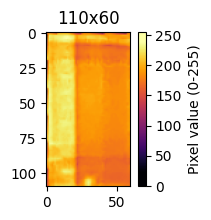

In [12]:

module.plot()

Affichage des stats :

In [13]:
display(pd.DataFrame.from_dict(module.stats, orient="index"))

,0
mean,192.039394
median,189.0
max,239
std,22.338687
min,22
p_0.05,166.0
p_0.10,169.0
p_0.15,173.0
p_0.20,175.0
p_0.25,179.0


Affichage de son histogramme :

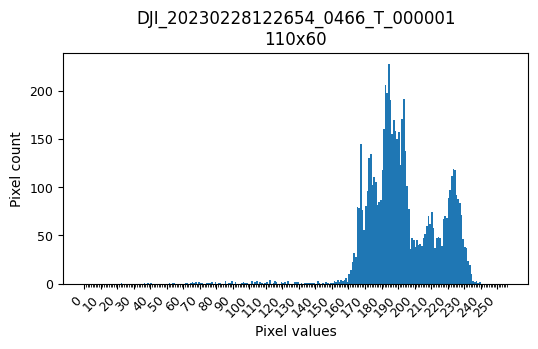

In [14]:
module.plot_histogram()

## Nombre de modules dans chaque statut

In [15]:
def get_count_and_percentage(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """Get the count and percentage of column 'col' categories in df"""

    count = df[col].value_counts()
    percentage = df[col].value_counts(normalize=True) * 100

    return pd.concat([count, percentage], axis=1)


In [16]:

get_count_and_percentage(df, "status")

,count,proportion
status,,
healthy panel,1519,27.227102
hot cell,946,16.956444
junction box heat,800,14.339487
substring open circuit,595,10.664994
short circuit panel,427,7.653701
Debris cover,410,7.348987
bottom dirt,377,6.757483
shadow,303,5.431081
break,131,2.348091


## Distribution des tailles de modules

Bien que l'on soit dans la catégorie "110x60", on s'aperçoit que les tailles de modules ne sont pas constantes.

In [17]:
get_count_and_percentage(df, "size")

,count,proportion
size,,
6600,5345,95.805700
3600,19,0.340563
3540,19,0.340563
3660,16,0.286790
3363,11,0.197168
3658,11,0.197168
3782,10,0.179244
3480,10,0.179244
3720,9,0.161319


On décide de créer un dataset en ne conservant que les modules de taille conforme.

In [18]:
df_size_filtered = df.loc[df["size"] == 6600]
df_size_filtered.shape

(5345, 285)

In [19]:
pd.concat([get_count_and_percentage(df, "status"), get_count_and_percentage(df_size_filtered, "status")], axis=1, keys=["not_filtered", "filtered"])

not_filtered            filtered           
                              count proportion    count proportion
status                                                            
healthy panel                  1519  27.227102     1460  27.315248
hot cell                        946  16.956444      847  15.846586
junction box heat               800  14.339487      800  14.967259
substring open circuit          595  10.664994      595  11.131899
short circuit panel             427   7.653701      427   7.988775
Debris cover                    410   7.348987      335   6.267540
bottom dirt                     377   6.757483      377   7.053321
shadow                          303   5.431081      303   5.668849
break                           131   2.348091      130   2.432180
string short circuit             71   1.272630       71   1.328344

Il semble préférable d'écarter les modules dont la taille n'est pas conforme.

In [20]:
df = df_size_filtered

## Affichage au hasard d'un module de chaque classe

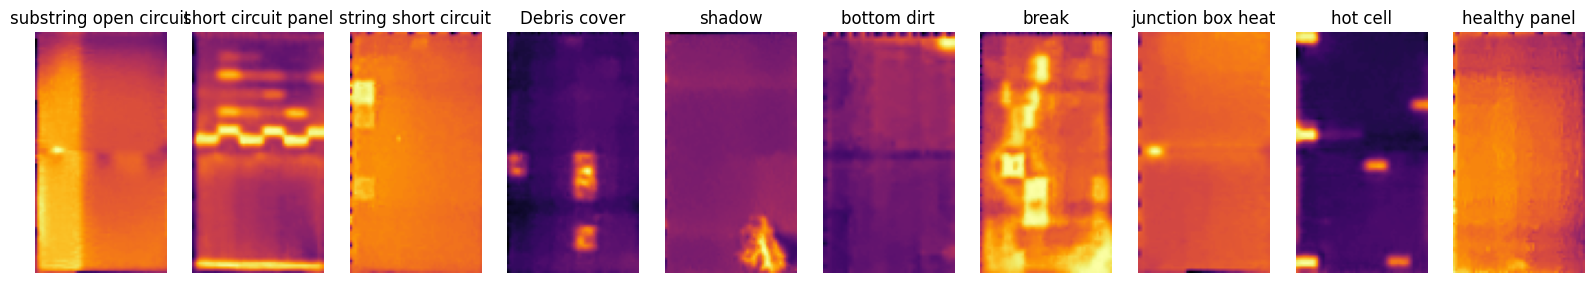

In [21]:
status_values = df["status"].unique()
fig, ax = plt.subplots(1, len(status_values), figsize=(20, 4))
idx_ax= 0

for status in status_values:
    module_idx = df.loc[df["status"] == status, "id"].sample(n=1).index.values[0]
    # print(modules[module_idx])
    ax[idx_ax].set_title(status)
    ax[idx_ax].axis('off')
    ax[idx_ax].imshow(modules[module_idx].array, cmap='inferno')
    idx_ax+=1

plt.show()

## Inspection de divers indicateurs statistiques en fonction du statut

### Min, Max, Mean et Median

La méthode `melt` de pandas.DataFrame permet de "dé-pivoter" des colonnes d'un dataframe.

In [22]:
df_melt = df.melt(id_vars=["id", "status"], value_vars=["min", "max", "mean", "median"])
df_melt = df_melt.rename(columns={"value": "pixel_value"})
display(df_melt)

,id,status,variable,pixel_value
0,DJI_20230228122654_0466_T_000001,substring open circuit,min,22.0
1,DJI_20230228122803_0500_T_000001,substring open circuit,min,32.0
2,DJI_20230228123425_0666_T_000002,substring open circuit,min,30.0
3,DJI_20230228124402_0129_T_000002,substring open circuit,min,31.0
4,DJI_20230228124624_0220_T_000001,substring open circuit,min,7.0
...,...,...,...,...
21375,DJI_20231121165445_0658_T_000004,healthy panel,median,65.0
21376,DJI_20231121165536_0682_T_000002,healthy panel,median,117.0
21377,DJI_20231121165610_0698_T_000002,healthy panel,median,112.0
21378,DJI_20231121165943_0012_T_000003,healthy panel,median,69.0


Ce qui permet ensuite de facilement créer un FacetGrid à l'aide de seaborn.

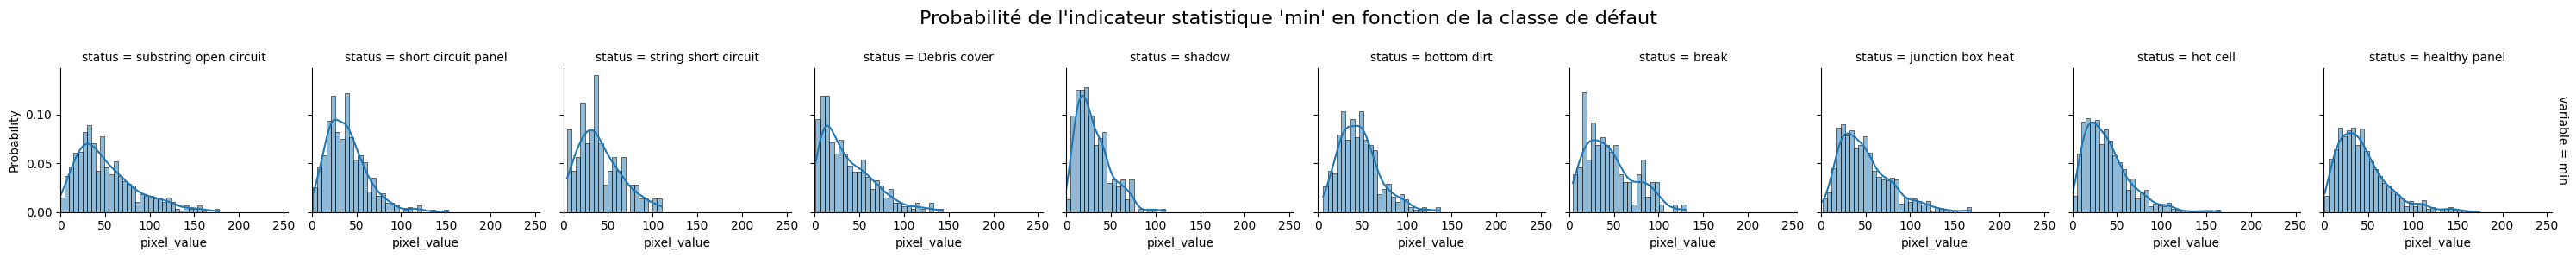

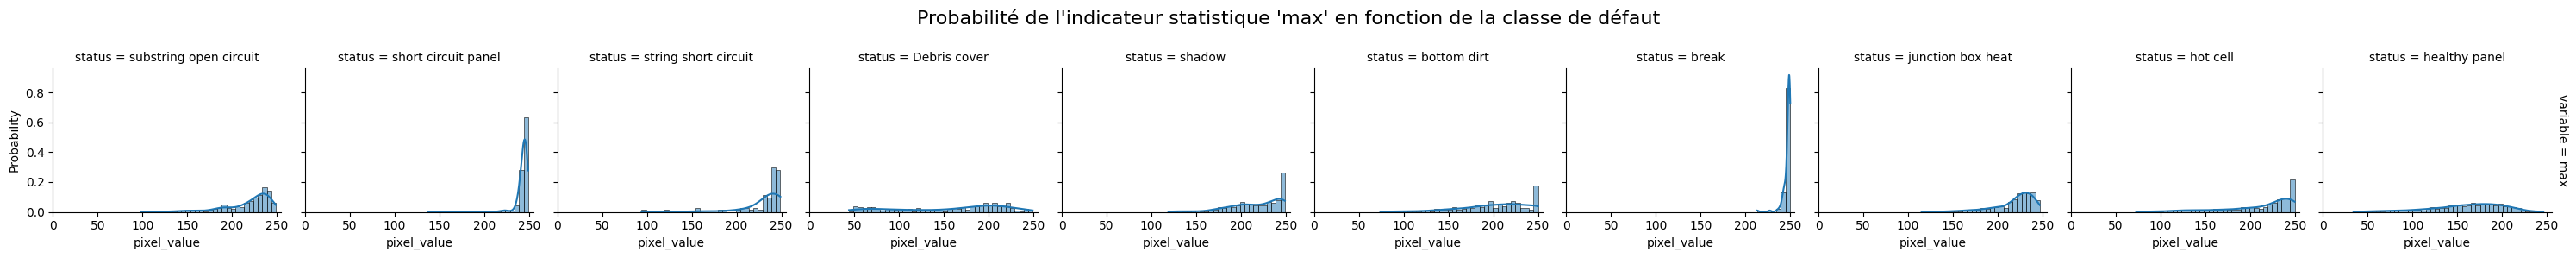

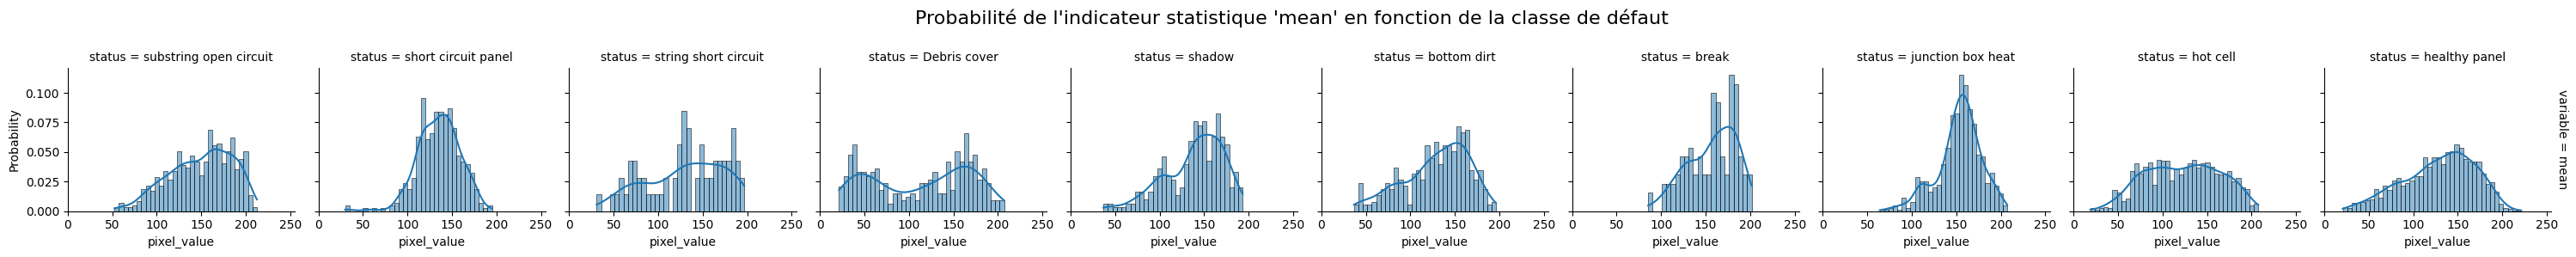

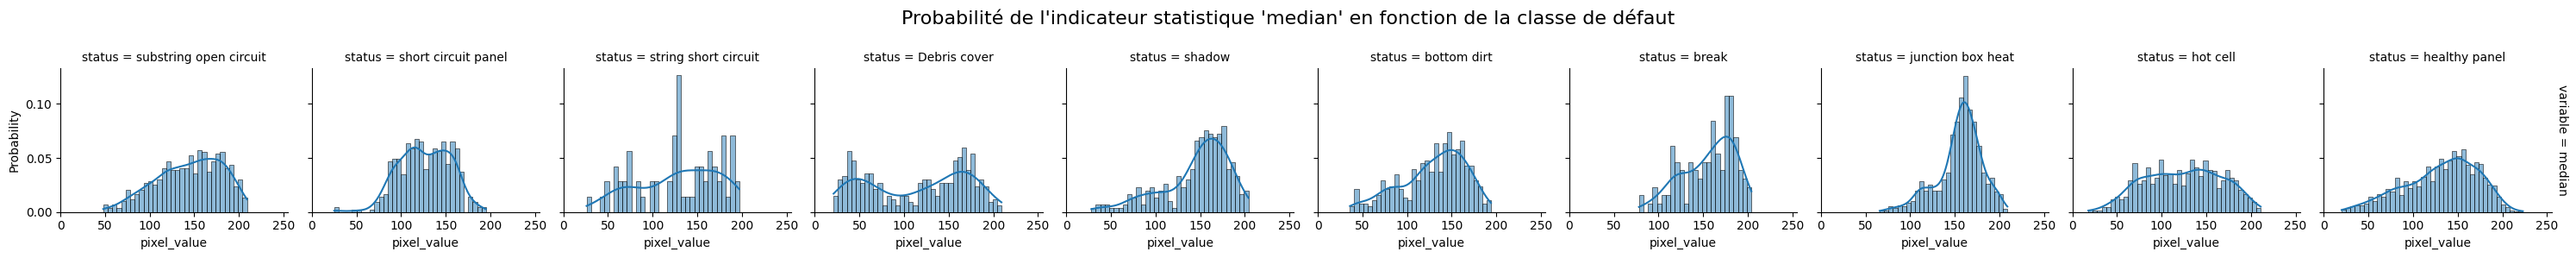

In [23]:
for indicator in df_melt["variable"].unique():
    
    g = sns.FacetGrid(df_melt.loc[df_melt["variable"] == indicator, :], row="variable", col="status", margin_titles=True, xlim=(0, 255))
    g.map(sns.histplot, "pixel_value", binwidth=5, stat="probability", kde=True)
    g.figure.subplots_adjust(top=0.75)
    g.figure.suptitle(f"Probabilité de l'indicateur statistique '{indicator}' en fonction de la classe de défaut", fontsize=16)
    plt.show()


En plus de la courbe de densité, qui peut avoir tendance à masquer certains détails, l'affichage de l'histogramme permet de mettre en évidence que la distribution de certains indicateurs est relativement "bruitée" au sein de chaque population.

A l'oeil, il est difficile de détecter des tendances vraiment significatives, à part les éléments suivants :
- sur l'indicateur "max" (valeur max de la matrice de pixels du module), les populations 'short circuit panel' et 'break' semblent se comporter différemment
- les indicateurs "mean" et "median" semblent assez proches l'un de l'autre
- pour "mean" et "median", la forme de la distribution semble différente selon le statut

Le fait qu'il n'est pas évident, pour un humain, de détecter des tendances, ne signifie pas que ces indicateurs sont inutilisables. Les modèles de machine learning sont justement là pour nous aider à identifier les relations entre features et variable cible, alors même qu'elles n'apparaissent pas de façon évidente.

### Histogramme global de chaque classe

In [24]:
histograms = {status: np.zeros((256,)) for status in df["status"].unique()}
for module in modules:
    histograms[module.status] = histograms[module.status] + module.histogram[0]

# histograms

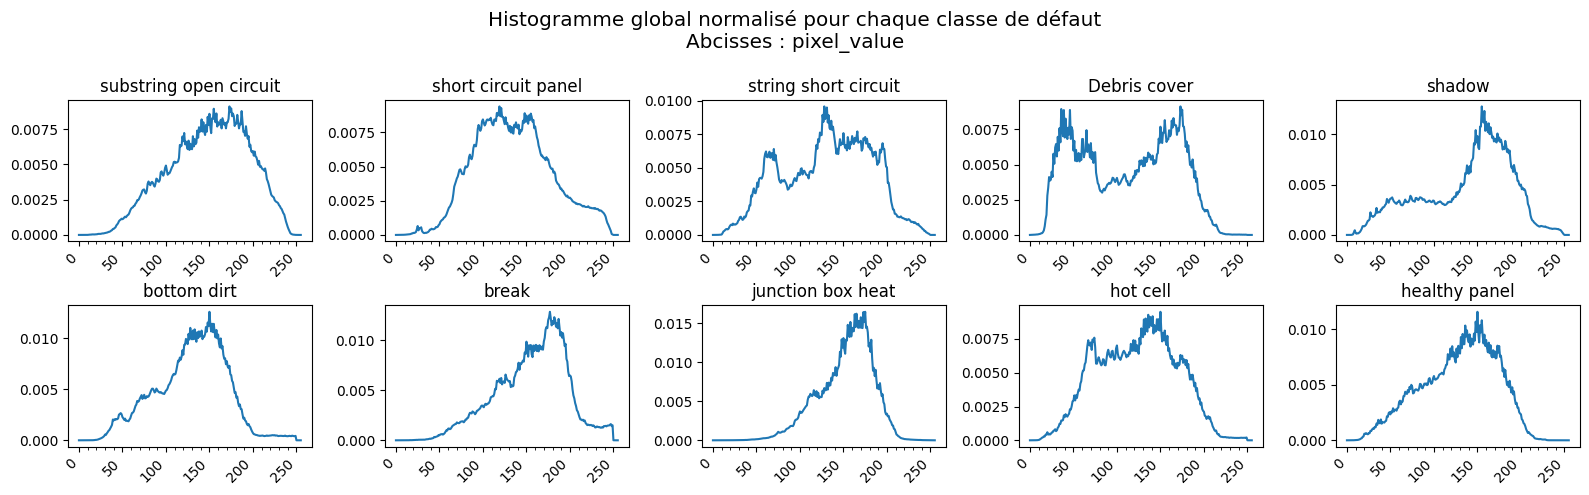

In [25]:
edges = module.histogram[1]

n_plot = 1
plt.figure(figsize=(16, 5))

for status, counts in histograms.items():
        
        plt.subplot(2, 5, n_plot)
        sns.lineplot(x=edges[:-1], y=counts / counts.sum())
        minor_ticks = [t for t in edges if t % 10 == 0]
        major_ticks = [t for t in edges if t % 50 == 0]
        plt.xticks(major_ticks, rotation=45, ha="right")
        plt.xticks(minor_ticks, minor=True)

        plt.title(status)

        n_plot += 1

plt.tight_layout()

plt.subplots_adjust(top=0.8)
plt.suptitle("Histogramme global normalisé pour chaque classe de défaut\nAbcisses : pixel_value", fontsize="x-large")

plt.show()


Ici on peut constater que la distribution des valeurs des pixels présente des différences en fonction de la classe de l'ensemble de modules considéré.

Ces différences devraient pouvoir être utilisées par un modèle de machine learning pour séparer les modules et retrouver la classe cible de chacun.

### Colonnes inutiles

On cherche les colonnes du dataframe dont l'écart-type est nul.

In [26]:
zero_std_df = df.describe().loc[:, df.describe().loc["std"] < 0.001]
zero_std_df

,size,hist_251,hist_252,hist_253,hist_254,hist_255
count,5345.0,5345.0,5345.0,5345.0,5345.0,5345.0
mean,6600.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0
min,6600.0,0.0,0.0,0.0,0.0,0.0
25%,6600.0,0.0,0.0,0.0,0.0,0.0
50%,6600.0,0.0,0.0,0.0,0.0,0.0
75%,6600.0,0.0,0.0,0.0,0.0,0.0
max,6600.0,0.0,0.0,0.0,0.0,0.0


Pour la colonne "size", c'est logique puisqu'on a supprimé tous les modules dont la taille n'était pas considérée comme conforme.

Les autres colonnes (celles commençant par 'hist_') seront à supprimer pour l'entraînement d'un modèle de Machine Learning.

# 4. Sauvegarde du jeu de données

On peut maintenant sauvegarder le jeu de données dans un csv.

In [27]:
FILE_NAME = f"modules_{FORMAT}_statistical_data.csv"

df.to_csv(Path(DATA_PATH) / FILE_NAME, index=False)